# Прогнозирование оттока клиентов банка

Из «Бета-Банка» стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

## Описание данных

Признаки:
* `RowNumber` - индекс строки в данных
* `CustomerId` - уникальный идентификатор клиента
* `Surname` - фамилия
* `CreditScore` - крединтный рейтинг
* `Geography` - страна проживания
* `Gender` - пол
* `Age` - возраст
* `Tenure` -  сколько лет человек является клиентом банка
* `Balance` - баланс на счёте
* `NumOfProducts` - количество продуктов банка, используемых клиентом
* `HasCrCard` - наличие кредитной карты
* `IsActiveMember` - активность клиента
* `EstimatedSalary` - предполагаемая зарплата

Целевой признак:
* `Exited` - факт ухода клиента


## Импорт библиотек

In [37]:
import pandas as pd
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import precision_recall_curve, classification_report 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve 
from sklearn.utils import shuffle 
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import re

import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")
RANDOM_STATE = 12345

## Загрузка и изучение датасета

In [38]:
try:
    df = pd.read_csv('/home/aart/datasets/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [39]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем названия в нижний регистр, проверим наличие явных дубликатов.

In [40]:
df = df.rename(columns=lambda column: re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower())
df.duplicated().sum()

0

Проверим наличие пропусков.

In [41]:
df.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

909 пропусков в столбце `tenure` - изучим их.

In [42]:
df[df['tenure'].isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


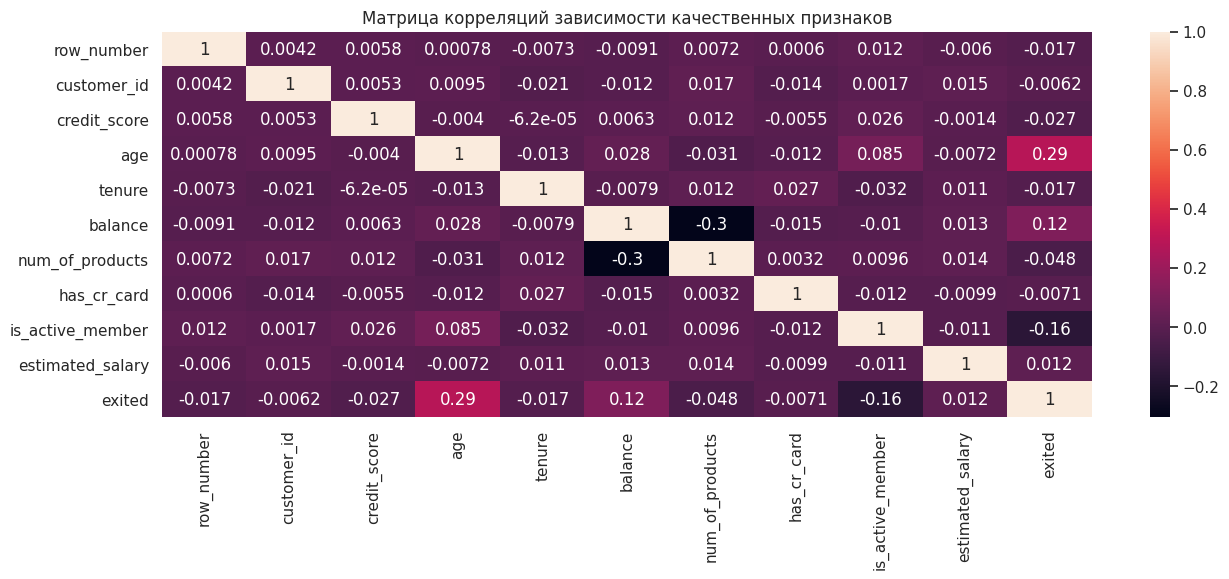

In [43]:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций зависимости качественных признаков')
sns.heatmap(df.corr(), annot = True)
plt.show()

Признаки коррелируют между собой слабо - выделяется только положительная корреляция в 0.29 между признаком `age` и `exited`, а так же негативная корреляция -0.3 между `numofproducts` и `balance`. Корреляция параметра `tenure` со всеми остальными - мала. В связи с этим, чтобы не удалять пропуски и не ухудшать результаты обучения моделей, мне кажется корректным замена пропусков на медиану.

In [44]:
df_filled = df
df_filled['tenure'] = df_filled['tenure'].fillna(df_filled['tenure'].median())

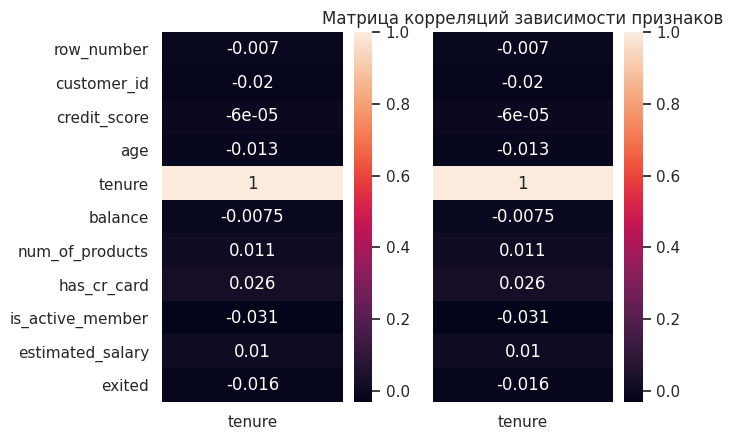

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2)
plt.title('Матрица корреляций зависимости признаков')

sns.heatmap(df.corr()[['tenure']], annot = True, ax=ax1)
sns.heatmap(df_filled.corr()[['tenure']], annot = True, yticklabels=False, ax=ax2)

plt.show()

Корреляции не поменялись, все в порядке. Заодно отбросим все столбцы, не играющие роли в обучении модели.

In [46]:
df = df_filled
df = df.drop(['surname', 'row_number', 'customer_id'], axis=1)

## Дисбаланс классов

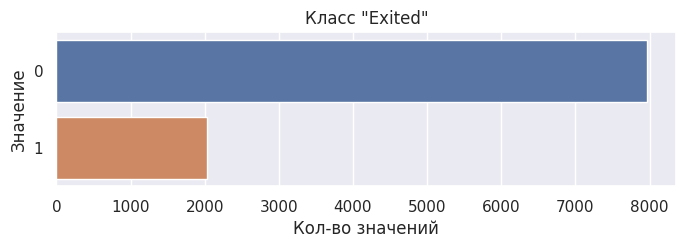

In [47]:
plt.figure(figsize=(8,2))
sns.countplot(data = df, y='exited')
plt.title('Класс "Exited"')
plt.xlabel('Кол-во значений')
plt.ylabel('Значение');

In [48]:
print('Доли значений:')
df['exited'].value_counts() / len(df)

Доли значений:


0    0.7963
1    0.2037
Name: exited, dtype: float64

Классы несбалансированы. В целях исследования указано сначала изучить поведение моделей без их взвешивания, но лучше исследовать дисбаланс сразу. 

## Стандартизация и OHE, разбиение на выборки

In [49]:
X = df.drop(['exited'], axis=1)
y = df['exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4,
                                                      random_state=RANDOM_STATE,stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5,
                                                    random_state=RANDOM_STATE,stratify=y_valid)

print('Размер тренировочной выборки:', X_train.shape[0])
print('Размер валидационной выборки:', X_valid.shape[0])
print('Размер тестовой выборки:',X_test.shape[0])

Размер тренировочной выборки: 6000
Размер валидационной выборки: 2000
Размер тестовой выборки: 2000


In [50]:
num_features = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = pd.DataFrame(scaler.transform(X_train[num_features]), columns=X_train[num_features].columns, \
                                                                            index=X_train[num_features].index)
X_valid[num_features] = pd.DataFrame(scaler.transform(X_valid[num_features]), columns=X_valid[num_features].columns, \
                                                                            index=X_valid[num_features].index)
X_test[num_features] = pd.DataFrame(scaler.transform(X_test[num_features]), columns=X_test[num_features].columns, \
                                                                            index=X_test[num_features].index)

In [52]:
cat_features = ['gender', 'geography']
ohe_encoder = OneHotEncoder(drop='first', sparse=False)

train_temp = ohe_encoder.fit_transform(X_train[cat_features]) #обучение и применение к train
X_train[ohe_encoder.get_feature_names()] = train_temp 
X_train.drop(cat_features, axis=1, inplace=True) 

valid_temp = ohe_encoder.transform(X_valid[cat_features]) #применение к valid
X_valid[ohe_encoder.get_feature_names()] = valid_temp 
X_valid.drop(cat_features, axis=1, inplace=True) 

test_temp = ohe_encoder.transform(X_test[cat_features]) #применение к test
X_test[ohe_encoder.get_feature_names()] = test_temp 
X_test.drop(cat_features, axis=1, inplace=True) 

## Исследование задачи без учета дисбаланса классов

### Логистическая регрессия

In [53]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("F1:", f1_score(y_valid, y_pred))
#вероятности пресдсказания положительного класса
prob_exited_val = model.predict_proba(X_valid)[:, 1]

F1: 0.2932330827067669


Результат неутешительный. Стоит попробовать найти оптимальный threshold.

In [54]:
f1 = pd.DataFrame()
for threshold in np.arange(0.05, 0.95, 0.05):
    y_pred = list(map(float, prob_exited_val > threshold))
    f1 = f1.append({
        'Порог'    : threshold, 
        'F1'       : f1_score(y_valid, y_pred)}, 
    ignore_index=True)

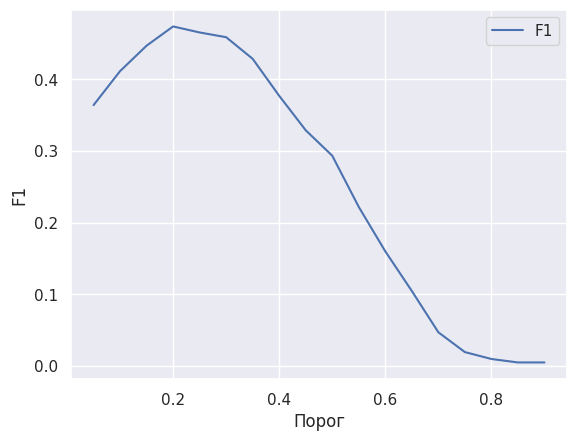

In [55]:
f1.plot(x='Порог', y='F1', ylabel='F1');

In [56]:
f1.sort_values(by='F1',ascending=False).head(3)

,F1,Порог
3,0.473552,0.20
4,0.465164,0.25
5,0.458537,0.30


Оптимальный порог для модели - 0.2. С ним F1-score модели равен ~0.47. Это неудовлетворительный результат.

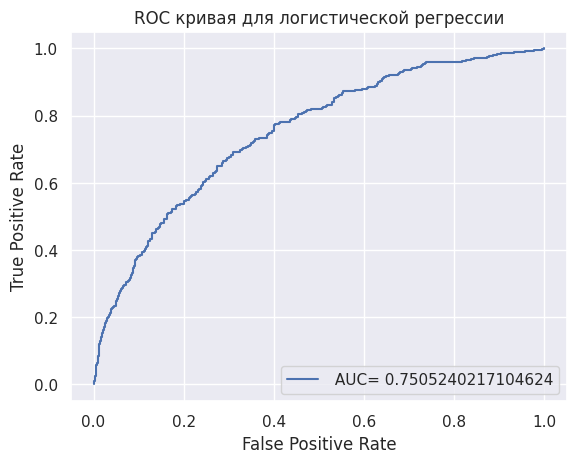

In [57]:
y_pred_proba = model.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для логистической регрессии')
plt.show() 

### Решающее дерево

In [58]:
best_depth = 0
f1_best = 0

for depth in range(2, 20):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)
    if f1 > f1_best:
        best_depth = depth
        f1_best = f1

In [59]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=best_depth)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("F1:", f1_score(y_valid, y_pred))

F1: 0.5520361990950227


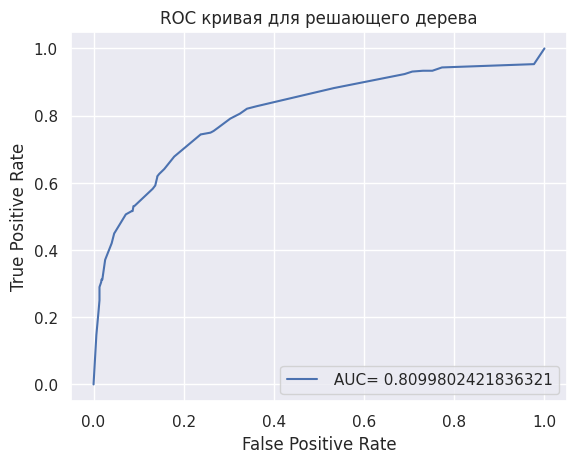

In [60]:
y_pred_proba = model.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для решающего дерева')
plt.show() 

Уже лучше, но результат неудовлетворителен. 

### Случайный лес

In [61]:
best_est = 0
best_depth = 0
f1_best = 0

for est in np.arange(5, 50, 5):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=depth, n_estimators=est)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        f1 = f1_score(y_valid, y_pred)
        if f1 > f1_best:
            best_depth = depth
            best_est=est
            f1_best = f1

In [62]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=best_depth, n_estimators=best_est)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("F1:", f1_score(y_valid, y_pred))

F1: 0.5561643835616439


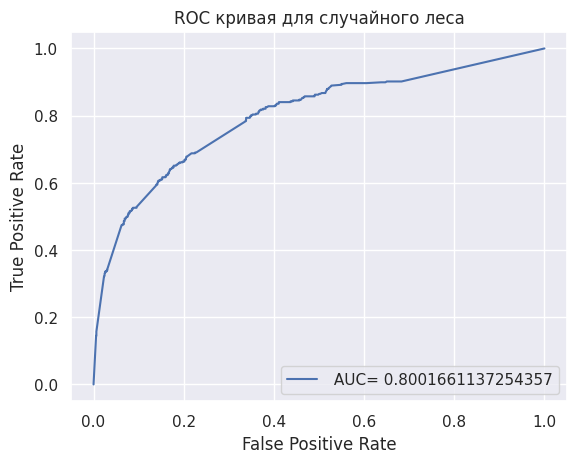

In [63]:
y_pred_proba = model.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для случайного леса')
plt.show() 

Это лучший результат на несбалансированной выборке:
 * F1-score = 0.55
 * AUC = 0.79

Тем не менее, результат неудовлетворительный, нужно сбалансировать классы.

## Борьба с дисбалансом

### Взвешивание

In [64]:
best_est = 0
best_depth = 0
f1_best = 0

for est in np.arange(5, 50, 5):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=depth, n_estimators=est, class_weight='balanced')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        f1 = f1_score(y_valid, y_pred)
        if f1 > f1_best:
            best_depth = depth
            best_est=est
            f1_best = f1

In [65]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=best_depth, n_estimators=best_est,class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("F1:", f1_score(y_valid, y_pred))

F1: 0.6146892655367232


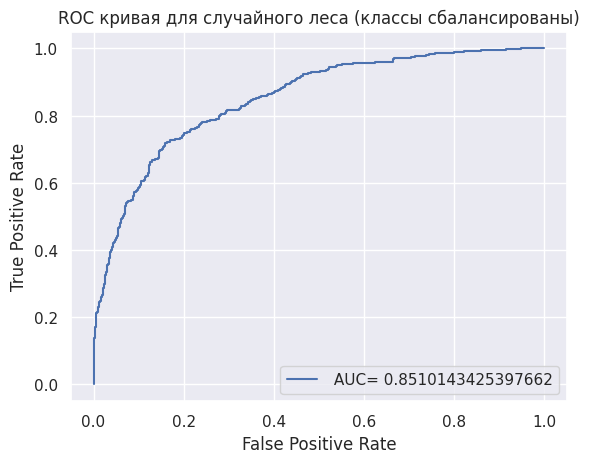

In [66]:
y_pred_proba = model.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для случайного леса (классы сбалансированы)')
plt.show() 

Результат при взвешивании классов удовлетворителен. Попробуем улучшить его.

### Up- и downsampling

Напишем фунеции для семплирования

In [67]:
def upsample(features, target, multiplier):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * multiplier)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * multiplier)
        
    return shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)


def downsample(features, target, divider):
    
    features_zeros = features[target == 0].sample(frac=divider, random_state=RANDOM_STATE)
    features_ones = features[target == 1]
    target_zeros = target[target == 0].sample(frac=divider, random_state=RANDOM_STATE)
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros] + [features_ones]) 
    target_downsampled = pd.concat([target_zeros] + [target_ones])
     
    return shuffle(features_downsampled, target_downsampled, random_state=RANDOM_STATE)

In [68]:
count = y_train.value_counts()

X_upsampled, y_upsampled = upsample(X_train, y_train, round(count[0]/count[1]))
X_downsampled, y_downsampled = downsample(X_train, y_train, count[1]/count[0])

Увеличение/уменьшение выборок происходит в ~4 раза, т.к. отношение классов примерно одна четвертая.

In [69]:
best_est_up = 0
best_depth_up = 0
f1_best_up = 0

for est in np.arange(5, 50, 5):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=depth, n_estimators=est)
        model.fit(X_upsampled, y_upsampled)
        y_pred = model.predict(X_valid)
        f1 = f1_score(y_valid, y_pred)
        if f1 > f1_best_up:
            best_depth_up = depth
            best_est_up=est
            f1_best_up = f1
            
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=best_depth_up, n_estimators=best_est_up)
model.fit(X_upsampled, y_upsampled)
y_pred = model.predict(X_valid)
print("F1 (upsampled):", f1_score(y_valid, y_pred))
print("Best depth (upsampled):", best_depth_up)
print("Best estimators (upsampled):", best_est_up)

F1 (upsampled): 0.6120331950207468
Best depth (upsampled): 8
Best estimators (upsampled): 35


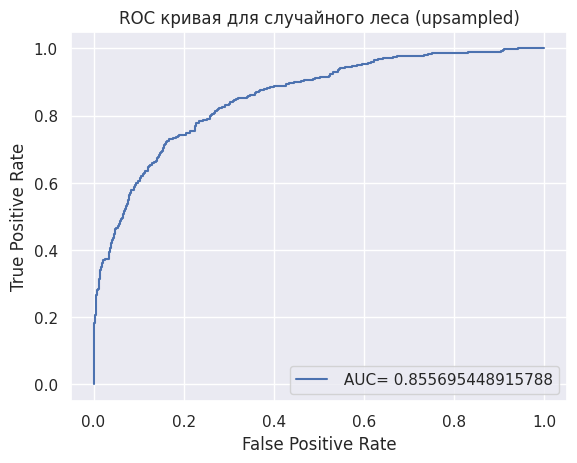

In [70]:
y_pred_proba = model.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для случайного леса (upsampled)')
plt.show() 

In [71]:
best_est_down = 0
best_depth_down = 0
f1_best_down = 0

for est in np.arange(5, 50, 5):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=depth, n_estimators=est)
        model.fit(X_downsampled, y_downsampled)
        y_pred = model.predict(X_valid)
        f1 = f1_score(y_valid, y_pred)
        if f1 > f1_best_down:
            best_depth_down = depth
            best_est_down=est
            f1_best_down = f1
            
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=best_depth_down, n_estimators=best_est_down)
model.fit(X_downsampled, y_downsampled)
y_pred = model.predict(X_valid)
print("F1 (downsampled):", f1_score(y_valid, y_pred))
print("Best depth (downsampled):", best_depth_down)
print("Best estimators (downsampled):", best_est_down)

F1 (downsampled): 0.5902578796561605
Best depth (downsampled): 7
Best estimators (downsampled): 45


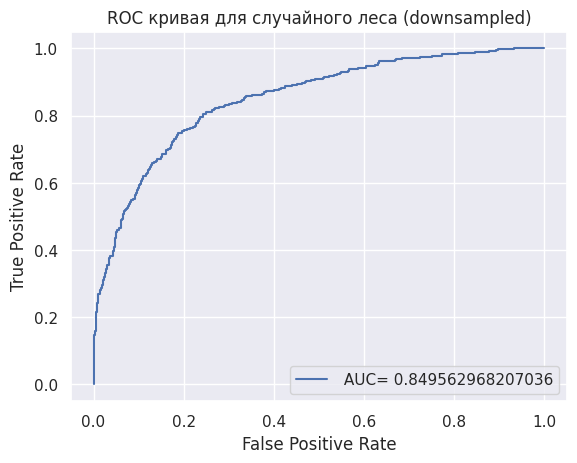

In [72]:
y_pred_proba = model.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для случайного леса (downsampled)')
plt.show() 

Как видим, в нашем случае upsampling работает немного лучше, чем простое взвешивание классов. Downsampling же работает значительно хуже. Остается лишь протестировать модель.

## Тестирование модели

In [73]:
final_model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=best_depth_up, n_estimators=best_est_up)
final_model.fit(X_upsampled, y_upsampled)
start = time.time()
fit_time = time.time() - start
print('F1-score validate: {:.4f}'.format(f1_score(y_valid, final_model.predict(X_valid))))
print('             test: {:.4f}'.format(f1_score(y_test, final_model.predict(X_test))))
print('Accuracy validate: {:.4f}'.format(final_model.score(X_valid, y_valid)))
print('             test: {:.4f}'.format(final_model.score(X_test, y_test)))
print('         fit time: {:.4f} s \n'.format(fit_time))

F1-score validate: 0.6120
             test: 0.6379
Accuracy validate: 0.8130
             test: 0.8240
         fit time: 0.0000 s 



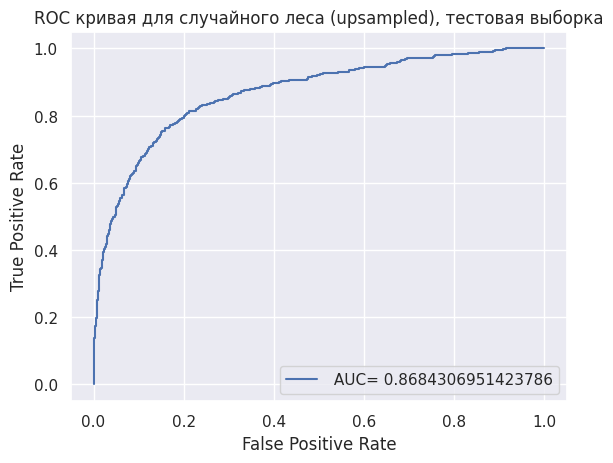

In [74]:
y_pred_proba = final_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC кривая для случайного леса (upsampled), тестовая выборка')
plt.show() 

Итого, лучшая полученная модель показывает следующие результаты на тестовой выборке:
   * F1-score: 0.63
   * Accuracy score: 0.82
   * AUC: 0.87

## Вывод

Датасет был предобработан, недочеты были устранены, он готов к последующей над ним работе.
В ходе исследования было изучено три модели: 
* Логистическая регрессия
* Дерево решений
* Случайный лес
Работа проходила следующим образом: каждую модель обучали и использовали на валидационной выборке **БЕЗ** учета дисбаланса классов. Для каждой модели оптимизировались гиперпараметры, и находились лучшие метрики F1-score и AUC. Также для каждой модели была построена ROC кривая. В результате этого исследования была выбрана модель, показавшая лучший результат (случайный лес). Оптимизация модели продолжилась, были применены три метода борьбы с дисбалансом - взвешивание, up- и downsampling. Из них был выбран лучший (upsampling). 
На тестовой выборке были получены результаты:
* F1-score: 0.63
* Accuracy score: 0.82
* AUC: 0.87
При требовании к F1-score >0.59. Была получена адекватная модель с хорошими показателями.